In [50]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

No face detected in D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers\smoking_33.png
No face detected in D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers\smoking_41.png
No face detected in D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers\smoking_45.png
No face detected in D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers\smoking_46.png
No face detected in D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers\smoking_50.png
No face detected in D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers\smoking_65.png
No f

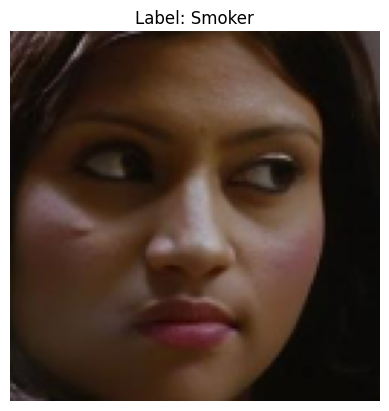

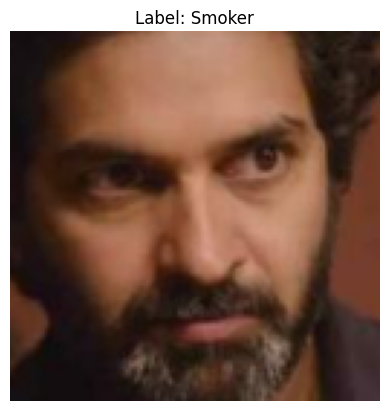

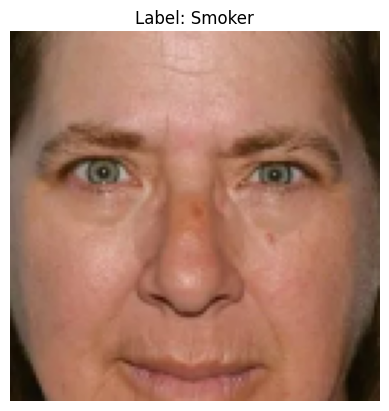

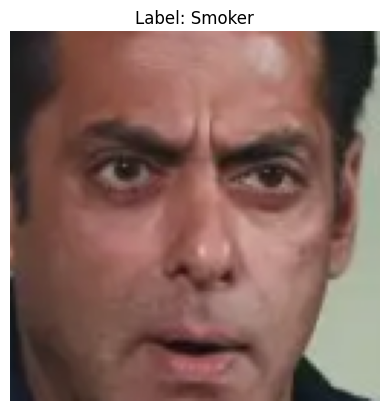

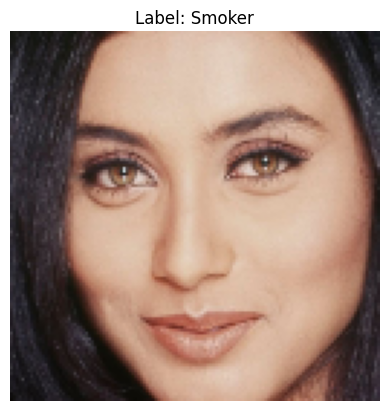

In [51]:

# Load Haar cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Paths to folders
base_dir = r'D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET'
smoker_dir = os.path.join(base_dir, 'Smokers')
nonsmoker_dir = os.path.join(base_dir, 'Non-Smoker')

# Collect all image paths
smoker_images = glob(os.path.join(smoker_dir, '*.jpg')) + glob(os.path.join(smoker_dir, '*.png'))
nonsmoker_images = glob(os.path.join(nonsmoker_dir, '*.jpg')) + glob(os.path.join(nonsmoker_dir, '*.png'))

image_paths = smoker_images + nonsmoker_images
labels = [1] * len(smoker_images) + [0] * len(nonsmoker_images)

# Store faces and their labels
aligned_faces = []
aligned_labels = []

# Face detection function
def detect_and_align_face_opencv(image_path, output_size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Image not found or unable to read: {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, output_size)
        return cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    else:
        print(f"No face detected in {image_path}")
        return None

# Process all images
for img_path, label in zip(image_paths, labels):
    face_img = detect_and_align_face_opencv(img_path)
    if face_img is not None:
        aligned_faces.append(face_img)
        aligned_labels.append(label)

# Example: display a few aligned faces
for i in range(min(5, len(aligned_faces))):
    plt.imshow(aligned_faces[i])
    plt.title(f"Label: {'Smoker' if aligned_labels[i] == 1 else 'Non-Smoker'}")
    plt.axis('off')
    plt.show()


In [52]:
import os
import cv2

# Make sure this function is already defined above:
# def detect_and_align_face(image_path): ...

# Set the full absolute path to the Smokers folder
input_folder = r'D:\Woxsen University\year 3\odd semester\data analysis and visualization\detection smoker and non smoker\research\DATA SET\Smokers'
output_folder = r'aligned_faces\smoker'

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process and save aligned faces
if os.path.exists(input_folder):
    for fname in os.listdir(input_folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, fname)
            face = detect_and_align_face(img_path)  # or detect_and_align_face_opencv(img_path)
            if face is not None:
                save_path = os.path.join(output_folder, fname)
                cv2.imwrite(save_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
                print(f"Saved: {save_path}")
else:
    print(f"Input folder '{input_folder}' does not exist.")


error: OpenCV(4.11.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x34dd5b3e::Set<3,4,-1>,struct cv::impl::A0x34dd5b3e::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [ ]:
# Wrinkle Detection using Hybrid Hessian Filter
def hybrid_hessian_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute gradients
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # Compute Hessian matrix
    hessian_xx = cv2.Sobel(gx, cv2.CV_64F, 1, 0, ksize=3)
    hessian_yy = cv2.Sobel(gy, cv2.CV_64F, 0, 1, ksize=3)
    hessian_xy = cv2.Sobel(gx, cv2.CV_64F, 0, 1, ksize=3)
    # Wrinkle map: sum of absolute Hessian responses
    wrinkle_map = np.abs(hessian_xx) + np.abs(hessian_yy) + np.abs(hessian_xy)
    wrinkle_map = cv2.normalize(wrinkle_map, None, 0, 255, cv2.NORM_MINMAX)
    return wrinkle_map.astype(np.uint8)


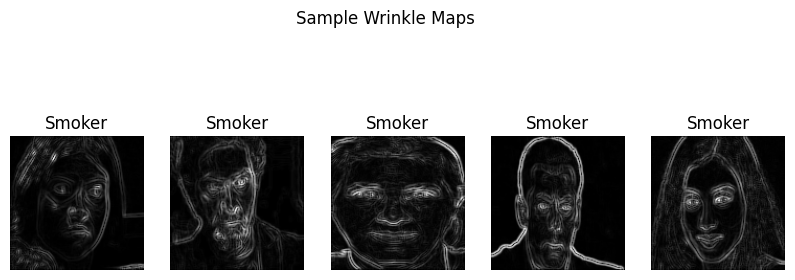

In [ ]:
#Model

IMG_SIZE = 128

def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    wrinkle = hybrid_hessian_filter(img)
    wrinkle = cv2.cvtColor(wrinkle, cv2.COLOR_GRAY2BGR)
    return wrinkle / 255.0  # Normalize

if df.empty:
    print("Error: DataFrame 'df' is empty. Please check your dataset and loading steps.")
    X = np.array([])
    y = np.array([])
else:
    X = np.array([preprocess_image(p) for p in df['image']])
    y = np.array(df['label'])

    # Visualization of a few wrinkle maps
    plt.figure(figsize=(10,4))
    for i in range(min(5, len(X))):
        plt.subplot(1,5,i+1)
        plt.imshow(X[i])
        plt.title('Smoker' if y[i]==1 else 'Non-Smoker')
        plt.axis('off')
    plt.suptitle('Sample Wrinkle Maps')
    plt.show()

In [ ]:
if len(X) == 0 or len(y) == 0:
	print("Error: No data available for splitting. Please check if your dataset is loaded correctly and df is not empty.")
else:
	X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


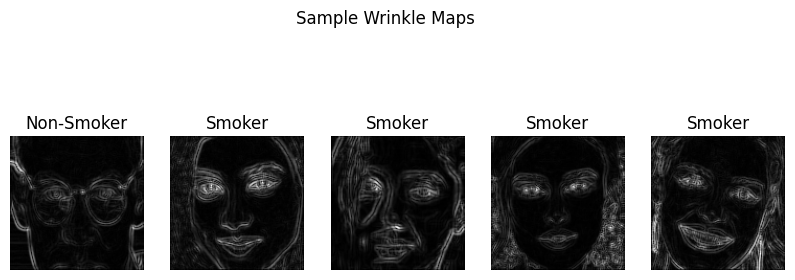

In [53]:
if 'X_train' in locals() and 'y_train' in locals() and len(X_train) > 0 and len(y_train) > 0:
    plt.figure(figsize=(10,4))
    for i in range(min(5, len(X_train))):
        plt.subplot(1,5,i+1)
        plt.imshow(X_train[i])
        plt.title('Smoker' if y_train[i]==1 else 'Non-Smoker')
        plt.axis('off')
    plt.suptitle('Sample Wrinkle Maps')
    plt.show()
else:
    print("Error: Training data not found. Please ensure your dataset is loaded and preprocessed correctly.")


In [38]:
#build CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


c:\Users\SAI GIRISH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
#model training
if 'X_train' in locals() and len(X_train) > 0 and len(y_train) > 0:
	history = model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2, verbose=1)
else:
	print("Error: Training data not found. Please ensure your dataset is loaded and preprocessed correctly.")


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.5037 - loss: 0.7065 - val_accuracy: 0.8500 - val_loss: 0.6678
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6644 - loss: 0.6511 - val_accuracy: 0.4500 - val_loss: 0.6853
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7349 - loss: 0.5467 - val_accuracy: 0.8000 - val_loss: 0.5371
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7612 - loss: 0.4884 - val_accuracy: 0.7000 - val_loss: 0.5696
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8209 - loss: 0.3949 - val_accuracy: 0.7500 - val_loss: 0.6121
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8772 - loss: 0.2777 - val_accuracy: 0.6500 - val_loss: 0.7627
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9747 - loss: 0.1576 - val_accuracy: 0.7000 - val_loss: 1.5363
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9950 - loss: 0.0706 - val_accuracy: 0.6500 - v

# Performance Evaluation

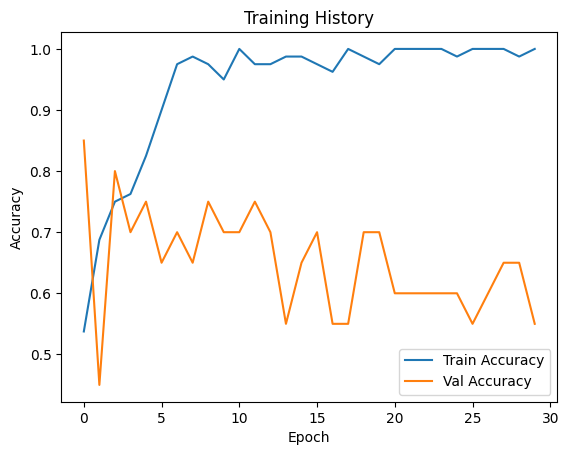

In [41]:
if 'history' in locals() and hasattr(history, 'history'):
	plt.plot(history.history['accuracy'], label='Train Accuracy')
	plt.plot(history.history['val_accuracy'], label='Val Accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.title('Training History')
	plt.show()
else:
	print("Error: No training history found. Please ensure the model was trained successfully.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
              precision    recall  f1-score   support

  Non-Smoker       0.69      0.75      0.72        12
      Smoker       0.75      0.69      0.72        13

    accuracy                           0.72        25
   macro avg       0.72      0.72      0.72        25
weighted avg       0.72      0.72      0.72        25



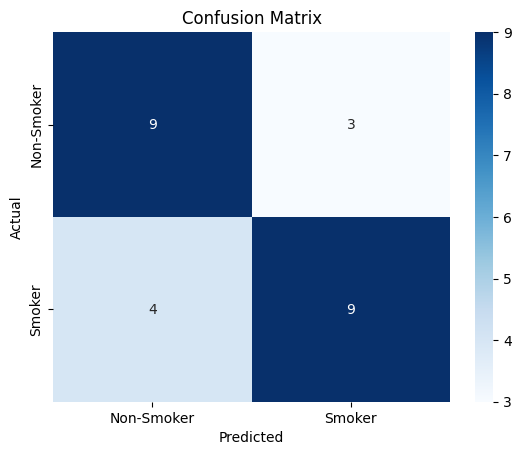

In [42]:
if 'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
	y_pred = (model.predict(X_test) > 0.5).astype("int32")
	print(classification_report(y_test, y_pred, target_names=['Non-Smoker', 'Smoker']))

	cm = confusion_matrix(y_test, y_pred)
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'])
	plt.xlabel('Predicted')
	plt.ylabel('Actual')
	plt.title('Confusion Matrix')
	plt.show()
else:
	print("Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.")


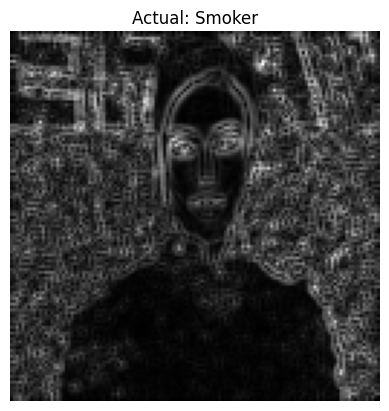

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[0] Predicted: Smoker | Confidence: 99.56%


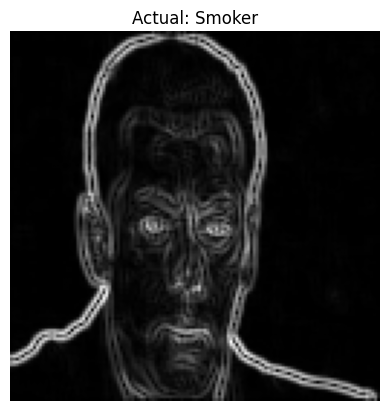

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[1] Predicted: Non-Smoker | Confidence: 100.00%


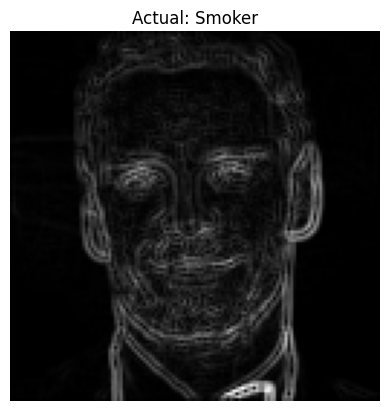

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[2] Predicted: Smoker | Confidence: 97.94%


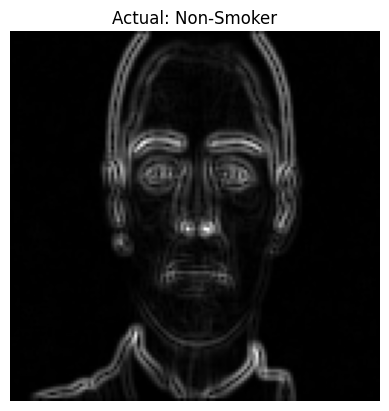

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[3] Predicted: Smoker | Confidence: 99.99%


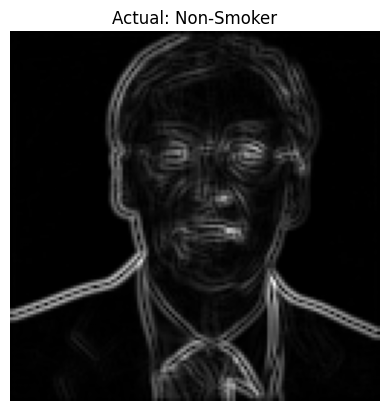

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[4] Predicted: Non-Smoker | Confidence: 100.00%


In [44]:
num_samples = 5  # or set to len(X_test) to run on all

if 'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
    for idx in range(min(num_samples, len(X_test))):
        sample = X_test[idx]
        plt.imshow(sample)
        plt.title(f'Actual: {"Smoker" if y_test[idx]==1 else "Non-Smoker"}')
        plt.axis('off')
        plt.show()

        # Model prediction
        pred = model.predict(np.expand_dims(sample, axis=0))[0][0]
        predicted_label = "Smoker" if pred > 0.5 else "Non-Smoker"
        confidence = pred*100 if pred > 0.5 else (1 - pred)*100
        print(f"[{idx}] Predicted: {predicted_label} | Confidence: {confidence:.2f}%")
else:
    print("Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.")



In [45]:
from sklearn.metrics import accuracy_score
import numpy as np

if 'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
    # Predict probabilities for all test samples
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels (0 or 1)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    print("✅ Test Accuracy: {:.2f}%".format(acc * 100))
else:
    print("❌ Error: Test data not found. Please ensure your dataset is loaded and preprocessed correctly.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
✅ Test Accuracy: 72.00%
